# **Importing Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install tensorflow==2.18.0 keras==3.6.0

In [2]:
import numpy as np
import pandas as pd
# import keras_tuner as kt
from matplotlib import pyplot as plt
import tensorflow as tf
from prophet import Prophet
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import InputLayer, Dense, LSTM, Dropout,GRU
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import seaborn as sns
import os
import datetime
import cv2

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.18.0
3.6.0


# **Reading CSV, Creat DataFrame**

In [50]:
# base_dir = '/content/drive/MyDrive/MTech Internship/interpolated_file.csv'
folder_path = (r"/content/drive/MyDrive/MTech Internship/bopal_solar_insolation_2016_2022_final.csv")
df = pd.read_csv(folder_path)
# print(df.head(20))

df['date_time'] = pd.to_datetime(df['date_time'], format = 'mixed')
df = df[(df['date_time'].dt.time >= pd.to_datetime('7:00').time()) &
                  (df['date_time'].dt.time <= pd.to_datetime('19:30').time())]
print(df.head(100))
print(df.shape)
# print(df.iloc[50:100])
# TESTING

folder_path_t = (r"/content/drive/MyDrive/MTech Internship/April_2023.csv")
df_t = pd.read_csv(folder_path_t)

df_t['date_time'] = pd.to_datetime(df_t['date_time'], format = 'mixed')
df_t = df_t[(df_t['date_time'].dt.time >= pd.to_datetime('7:00').time()) &
                  (df_t['date_time'].dt.time <= pd.to_datetime('19:30').time())]
# df_t = df_t.head(260)
print(df_t.head(20))
print(df_t.shape)

             date_time      ghi
0  2016-01-01 07:00:00    0.000
1  2016-01-01 07:30:00    0.000
2  2016-01-01 08:00:00    0.000
3  2016-01-01 08:30:00    0.000
4  2016-01-01 09:00:00   63.336
..                 ...      ...
95 2016-01-04 15:30:00  376.831
96 2016-01-04 16:00:00  322.086
97 2016-01-04 16:30:00  193.469
98 2016-01-04 17:00:00  127.113
99 2016-01-04 17:30:00   25.190

[100 rows x 2 columns]
(66482, 2)
             date_time         ghi
14 2023-01-04 07:00:00   58.891666
15 2023-01-04 07:30:00  159.210000
16 2023-01-04 08:00:00  281.133330
17 2023-01-04 08:30:00  401.043330
18 2023-01-04 09:00:00  518.486700
19 2023-01-04 09:30:00  643.250000
20 2023-01-04 10:00:00  745.021670
21 2023-01-04 10:30:00  828.308350
22 2023-01-04 11:00:00  909.380000
23 2023-01-04 11:30:00  948.458300
24 2023-01-04 12:00:00  961.218300
25 2023-01-04 12:30:00  985.858340
26 2023-01-04 13:00:00  997.028300
27 2023-01-04 13:30:00  980.911700
28 2023-01-04 14:00:00  952.806640
29 2023-01-04 14:30:0

In [ ]:
# df_t = pd.DataFrame(df_t)


# # Filter the data to include only entries from Jan 1st to Jan 10th
# start_date = '01-01-2024'
# end_date = '01-11-2024'
# mask = (df_t['date_time'] >= start_date) & (df_t['date_time'] < end_date)
# filtered_data = df.loc[mask]

# # Display the filtered data
# print(filtered_data)

# **Preprocessing**

In [51]:
starting_timestamp = "2016/01/01 0:00"
ending_timestamp = "2022/12/31 23:30"
array_range = pd.date_range(start=starting_timestamp, end=ending_timestamp, freq='30T')

array_timestamps = []

start_time = pd.to_datetime("7:00 AM").time()
end_time = pd.to_datetime("7:00 PM").time()
max_end_time = pd.to_datetime("7:30 PM").time()

for timestamp in array_range:
    if timestamp.time() >= start_time and timestamp.time() <= end_time:
        array_timestamps.append(timestamp)
    elif timestamp.time() > end_time and timestamp.time() <= max_end_time:
        array_timestamps.append(timestamp)


df_date = pd.DataFrame({'date_time':array_timestamps})
df_date.set_index('date_time')

p_df = pd.merge(df_date, df, on ='date_time', how='left')
# print(p_df.head(40))

cols = list(p_df)[1]
print(cols)

df_for_training = p_df[cols].astype(float)
        # print(df_for_training.head(10))
df_for_training = df_for_training.dropna()
# df_for_training.to_csv(os.path.join(base_dir,"interpolated_file.csv"),header=True)
print(df_for_training.head(40))
print(df_for_training.shape)
df_for_training = np.array(df_for_training).reshape(-1,1)




# TESTING

starting_timestamp_t = "04/01/2023 0:00"
ending_timestamp_t = "05/15/2023 23:30"
array_range_t = pd.date_range(start=starting_timestamp_t, end=ending_timestamp_t, freq='30T')

array_timestamps_t = []
start_time_t = pd.to_datetime("7:00 AM").time()
end_time_t = pd.to_datetime("7:00 PM").time()
max_end_time_t = pd.to_datetime("7:30 PM").time()

for timestamp_t in array_range_t:
    if timestamp_t.time() >= start_time_t and timestamp_t.time() <= end_time_t:
        array_timestamps_t.append(timestamp_t)
    elif timestamp_t.time() > end_time_t and timestamp_t.time() <= max_end_time_t:
        array_timestamps_t.append(timestamp_t)

df_date_t = pd.DataFrame({'date_time':array_timestamps_t})
df_date_t.set_index('date_time')
p_df_t = pd.merge(df_date_t, df_t, on ='date_time', how='left')

cols_t = list(df_t)[1]
print(cols)
df_for_testing = df_t[cols].astype(float)
        # print(df_for_testing.head(10))
df_for_testing = df_for_testing.dropna()
# df_for_testing.to_csv(os.path.join(base_dir,"interpolated_file.csv"),header=True)
print(df_for_testing.head(60))
# print(p_df_t.head(150))
print(df_for_testing.shape)
df_for_testing = np.array(df_for_testing).reshape(-1,1)


<ipython-input-51-513e3fc4dc35>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  array_range = pd.date_range(start=starting_timestamp, end=ending_timestamp, freq='30T')


ghi
0       0.000
1       0.000
2       0.000
3       0.000
4      63.336
5      85.460
6     232.009
7     261.788
8     344.058
9     426.328
10    533.932
11    596.620
12    593.633
13    596.862
14    574.698
15    516.912
16    476.647
17    371.110
18    315.488
19    187.728
20    120.578
21     21.805
22      0.000
23      0.000
24      0.000
25      0.000
26      0.000
27      0.000
28      0.000
29     42.220
30     63.555
31    197.796
32    231.993
33    373.987
34    445.619
35    517.250
36    531.404
37    596.288
38    594.129
39    596.755
Name: ghi, dtype: float64
(66482,)
ghi
14      58.891666
15     159.210000
16     281.133330
17     401.043330
18     518.486700
19     643.250000
20     745.021670
21     828.308350
22     909.380000
23     948.458300
24     961.218300
25     985.858340
26     997.028300
27     980.911700
28     952.806640
29     859.728330
30     613.608340
31     596.555000
32     495.641660
33     418.756650
34     323.691680
35     156.463330
3

<ipython-input-51-513e3fc4dc35>:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  array_range_t = pd.date_range(start=starting_timestamp_t, end=ending_timestamp_t, freq='30T')


In [52]:
max_value = p_df['ghi'].max()
min_value = p_df['ghi'].min()
print(max_value,min_value)

1001.75 0.0


# **Handling Missing Values**


In [ ]:

def missingValUsingMedian(missing_val_date):

    print("Neighbouring values not available")
    print("Find previous 3 days values and perform median operation")

    dt = missing_val_date
    prev_dates_lst = []
    prev_values_lst = []
    for k in range(3):
        dt1 = dt - datetime.timedelta(days=k+1)
        dt_str = dt1.strftime("%Y-%m-%d %H:%M")
        prev_dates_lst.append(dt_str)
        value = df[df['date_time'] == dt_str][col].values[0]
        if value != None:
            print(value)
            prev_values_lst.append(value)
    print(prev_values_lst)
    missing_val = np.nanmedian(prev_values_lst)
    print(missing_val)

    return missing_val

for col in p_df.columns:
    print(col)
    for i, row in p_df.iterrows():
        dt = row[0]
        if i==0:
            pass
        else:
            if pd.isnull(p_df.loc[i][col]):
                print("Value null for dt::",row[0])
                if not pd.isnull(p_df.loc[i-1][col]):
                    if not pd.isnull(p_df.loc[i+1][col]):
                        p_df.loc[i,col] = (p_df.loc[i-1][col] + p_df.loc[i+1][col])/2
                        print(p_df.loc[i, col])
                        # p_df[col].replace(p_df.loc[i,col], new_val, inplace = True)
                        print("Replaced Value:", p_df.loc[i, col])

                    elif not pd.isnull(p_df.loc[i+2][col]):
                        print("here--1")
                        p_df.loc[i,col] = (p_df.loc[i-1][col] + p_df.loc[i+2][col])/2
                        # p_df.replace(p_df.loc[i,col], new_val, inplace = True)
                    else:
                        replaced_val = missingValUsingMedian(dt)
                        print("missing Values::",replaced_val)
                        p_df.loc[i,col]= replaced_val
                        p_df.replace(p_df.loc[i,col], replaced_val, inplace = True)
                        print("Replaced Value:", p_df.loc[i, col])
                else:
                    replaced_val = missingValUsingMedian(dt)
                    print("missing Values::",replaced_val)
                    p_df.loc[i,col]= replaced_val
                    # p_df.replace(p_df.loc[i,col], replaced_val, inplace = True)
                    print("Replaced Value:", p_df.loc[i, col])



date_time


<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]


ghi
Value null for dt:: 2022-01-04 07:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
0.455
0.5183333
0.535
[0.455, 0.5183333, 0.535]
0.5183333
missing Values:: 0.5183333
Replaced Value: 0.5183333
Value null for dt:: 2022-01-04 07:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
18.868334
22.358334
11.283334
[18.868334, 22.358334, 11.283334]
18.868334
missing Values:: 18.868334
Replaced Value: 18.868334
Value null for dt:: 2022-01-04 08:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
59.55
70.66
31.163334
[59.55, 70.66, 31.163334]
59.55
missing Values:: 59.55
Replaced Value: 59.55
Value null for dt:: 2022-01-04 08:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
141.57
145.96
160.01666
[141.57, 145.96, 160.01666]
145.96
missing Values:: 145.96
Replaced Value: 145.96
Value null for dt:: 2022-01-0

<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

0.0
45.913334
45.461666
[0.0, 45.913334, 45.461666]
45.461666
missing Values:: 45.461666
Replaced Value: 45.461666
Value null for dt:: 2022-01-04 18:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
0.0
5.6466665
5.3766665
[0.0, 5.6466665, 5.3766665]
5.3766665
missing Values:: 5.3766665
Replaced Value: 5.3766665
Value null for dt:: 2022-01-04 18:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
0.0
0.0
0.0
[0.0, 0.0, 0.0]
0.0
missing Values:: 0.0
Replaced Value: 0.0
Value null for dt:: 2022-01-04 19:00:00
here--1
Value null for dt:: 2022-01-04 19:30:00
0.24875001
Replaced Value: 0.24875001
Value null for dt:: 2022-01-19 07:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
0.265
0.27333334
0.3
[0.265, 0.27333334, 0.3]
0.27333334
missing Values:: 0.27333334
Replaced Value: 0.27333334
Value null for dt:: 2022-01-19 07:30:00
Neighbouring values not av

<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

Value null for dt:: 2022-01-19 14:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
710.91
660.505
661.1583
[710.91, 660.505, 661.1583]
661.1583
missing Values:: 661.1583
Replaced Value: 661.1583
Value null for dt:: 2022-01-19 14:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
656.36
613.98
607.4217
[656.36, 613.98, 607.4217]
613.98
missing Values:: 613.98
Replaced Value: 613.98
Value null for dt:: 2022-01-19 15:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
583.92334
543.93835
537.995
[583.92334, 543.93835, 537.995]
543.93835
missing Values:: 543.93835
Replaced Value: 543.93835
Value null for dt:: 2022-01-19 15:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
493.31332
467.30167
450.39667
[493.31332, 467.30167, 450.39667]
467.30167
missing Values:: 467.30167
Replaced Value: 467.30167
Value null

<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

Replaced Value: 755.2833
Value null for dt:: 2022-01-26 12:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
814.01166
778.43835
728.7833
[814.01166, 778.43835, 728.7833]
778.43835
missing Values:: 778.43835
Replaced Value: 778.43835
Value null for dt:: 2022-01-26 13:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
815.845
784.9667
726.3883
[815.845, 784.9667, 726.3883]
784.9667
missing Values:: 784.9667
Replaced Value: 784.9667
Value null for dt:: 2022-01-26 13:30:00
Neighbouring values not available
Find previous 3 days values and perform median operation
798.95667
777.0883
727.375
[798.95667, 777.0883, 727.375]
777.0883
missing Values:: 777.0883
Replaced Value: 777.0883
Value null for dt:: 2022-01-26 14:00:00
Neighbouring values not available
Find previous 3 days values and perform median operation
771.0467
734.83
685.3383
[771.0467, 734.83, 685.3383]
734.83
missing Values:: 734.83
Replace

<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Value null for dt::",row[0])
<ipython-input-5-8cfcb58865e1>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = row[0]
<ipython-input-5-8cfcb58865e1>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, i

IndexError: index 0 is out of bounds for axis 0 with size 0

In [53]:
e = 50   # epochs
n_past=26*7   # Number of past days we want to use to predict the future.
n_future = 26*3   # Number of days we want to look into the future based on the past days.
n_features = 1   # Single variate


# **Making Windows**

In [54]:

# Empty lists to be populated using formatted training data
dataX, dataY = [], []

for i in range(0,len(df_for_training)-n_past-n_future):
    a = df_for_training[i:(i+n_past), 0]
    dataX.append(a)
    b = df_for_training[i + n_past:i + n_past + n_future, 0]
    dataY.append(b)
dataX, dataY = np.array(dataX), np.array(dataY)

# print(dataX)
print(dataX.shape,dataY.shape)
# print(dataY)

# TESTING

dataX_t, dataY_t = [], []
# print(df_for_testing)
for i in range(0,len(df_for_testing)-n_past-n_future):
    a = df_for_testing[i:(i+n_past), 0]
    dataX_t.append(a)
    b = df_for_testing[i + n_past:i + n_past + n_future, 0]
    dataY_t.append(b)
dataX_t, dataY_t = np.array(dataX_t), np.array(dataY_t)

print(dataX_t.shape,dataY_t.shape)
print(dataX_t)
print(dataY_t)


(66222, 182) (66222, 78)
(520, 182) (520, 78)
[[ 58.891666  159.21      281.13333   ...  49.90167     3.3616667
    0.       ]
 [159.21      281.13333   401.04333   ...   3.3616667   0.
   61.836666 ]
 [281.13333   401.04333   518.4867    ...   0.         61.836666
  155.95     ]
 ...
 [ 29.333334    4.08        0.        ... 354.32166   253.70334
  118.96     ]
 [  4.08        0.         96.80666   ... 253.70334   118.96
   44.43667  ]
 [  0.         96.80666   211.07834   ... 118.96       44.43667
    4.3533335]]
[[ 61.836666  155.95      273.32      ...  35.798332    1.9483334
    0.       ]
 [155.95      273.32      396.37      ...   1.9483334   0.
   72.81834  ]
 [273.32      396.37      504.11835   ...   0.         72.81834
  178.65334  ]
 ...
 [ 44.43667     4.3533335   0.        ... 570.19666   566.73334
  521.9267   ]
 [  4.3533335   0.        104.253334  ... 566.73334   521.9267
  510.43832  ]
 [  0.        104.253334  203.93666   ... 521.9267    510.43832
  330.37668  ]]


# **Scaling**

In [55]:

scalerX = MinMaxScaler(feature_range=(0, 1))
scalerX = scalerX.fit(dataX)
dataX_scaled = scalerX.transform(dataX)
print(dataX_scaled[:10])
counts = np.isnan(dataX_scaled).sum()
print(counts)


scalerY = MinMaxScaler(feature_range=(0, 1))
scalerY = scalerY.fit(dataY)
dataY_scaled = scalerY.transform(dataY)
print(dataY_scaled[:10])
counts = np.isnan(dataY_scaled).sum()
print(counts)

dataX_scaled = dataX_scaled.reshape((dataX_scaled.shape[0], dataX_scaled.shape[1], 1))
dataY_scaled = dataY_scaled.reshape((dataY_scaled.shape[0],dataY_scaled.shape[1], 1))

print(dataX_scaled.shape,dataY_scaled.shape)
# # df_for_training_scaled = (df_for_training - min_value) /(max_value - min_value)
# # print(df_for_training)

# df_for_testing_scaled = scaler.transform(df_for_testing)
# print(df_for_testing_scaled[:10])
# # counts = np.isnan(df_for_training_scaled).sum()


# print(df_for_testing)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.06322536 ... 0.         0.         0.        ]
 ...
 [0.26133067 0.34345695 0.42558323 ... 0.06473771 0.19844273 0.23349538]
 [0.34345695 0.42558323 0.53299925 ... 0.19844273 0.23349538 0.37561867]
 [0.42558323 0.53299925 0.59557774 ... 0.23349538 0.37561867 0.44813177]]
0
[[0.         0.         0.         0.04287896 0.06473771 0.19844273
  0.23349538 0.37561867 0.44813177 0.52064487 0.53762815 0.60121288
  0.59943299 0.60249264 0.58288096 0.55128924 0.48619416 0.43736761
  0.32709858 0.19869229 0.1334874  0.02984377 0.         0.
  0.         0.         0.         0.         0.         0.03673471
  0.05824707 0.18118992 0.21656202 0.35084602 0.42070776 0.4905705
  0.50869978 0.5686309  0.56755278 0.56944946 0.54820065 0.51597005
  0.45256801 0.40195158 0.29644422 0.23134914 0.1138877  0.04091141
  0.         0.    

In [56]:
scalerX_test = MinMaxScaler(feature_range=(0, 1))
scalerX_test = scalerX_test.fit(dataX_t)
dataX_test_scaled = scalerX_test.transform(dataX_t)
print(dataX_test_scaled[:10])
counts = np.isnan(dataX_test_scaled).sum()
print(counts)


scalerY_test = MinMaxScaler(feature_range=(0, 1))
scalerY_test = scalerY_test.fit(dataY_t)
dataY_test_scaled = scalerY.transform(dataY_t)
print(dataY_test_scaled[:10])
counts = np.isnan(dataY_test_scaled).sum()
print(counts)


dataX_test_scaled = dataX_test_scaled.reshape((dataX_test_scaled.shape[0], dataX_test_scaled.shape[1], 1))
dataY_test_scaled = dataY_test_scaled.reshape((dataY_test_scaled.shape[0], dataY_test_scaled.shape[1], 1))
print(dataX_test_scaled.shape,dataY_test_scaled.shape)

[[0.05519602 0.14921904 0.26349127 ... 0.04462552 0.00300623 0.        ]
 [0.14921904 0.26349127 0.37587652 ... 0.00300623 0.         0.05529862]
 [0.26349127 0.37587652 0.48594992 ... 0.         0.05529862 0.13946126]
 ...
 [0.77632923 0.85231336 0.88893936 ... 0.45081744 0.54426407 0.63294423]
 [0.85231336 0.88893936 0.90089863 ... 0.54426407 0.63294423 0.7188969 ]
 [0.88893936 0.90089863 0.92399243 ... 0.63294423 0.7188969  0.78383129]]
0
[[0.06172864 0.15567756 0.27284253 0.39567756 0.50323768 0.60755013
  0.70654185 0.80248894 0.8749738  0.92623908 0.95233006 0.96504617
  0.96275853 0.95109724 0.90801268 0.87347977 0.78111139 0.66860494
  0.44068215 0.24147076 0.08090009 0.07542301 0.07738624 0.0193345
  0.00135929 0.         0.06773314 0.15901006 0.27777223 0.40296148
  0.51110721 0.60304637 0.72403957 0.81536142 0.88054904 0.92814574
  0.95508525 0.97065306 0.96913901 0.95975877 0.83443641 0.86189838
  0.77990683 0.68833711 0.58857999 0.45731804 0.34372514 0.22837202
  0.1125913

In [57]:
print(df_for_testing.shape)

(780, 1)


# **Train-Test Split**

In [ ]:
# SPLIT = 0.8
# X_train = dataX[:int(SPLIT * len(dataX))]
# y_train = dataY[:int(SPLIT * len(dataY))]
# X_test = dataX[int(SPLIT * len(dataX)):]
# y_test = dataY[int(SPLIT * len(dataY)):]
# print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

# # Reshape trainX for LSTM input (samples, timesteps, features)
# TrainX = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Assuming one feature for LSTM
# # TestX = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# TrainY = y_train.reshape((y_train.shape[0],y_train.shape[1], 1))
# # TestY = y_test.reshape(y_test.shape[0])
# print(TrainX.shape,TrainY.shape)
# print(y_test)

# **Models**

In [ ]:
# # Define the LSTM model

def model_1 (input_shape, dropout_rate, units, output_size):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(input_shape, 1)))
    # model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    # model.add(Dropout(dropout_rate))
    # model.add(LSTM(units))
    # model.add(Dropout(dropout_rate))
    model.add(Dense(output_size, activation='relu'))  # Output layer with the shape of trainY
    # Compile the model
    model.compile(optimizer='Adam', loss='mean_squared_error', metrics=[MeanSquaredError()])
    model.summary()
    return model


input_shape=dataX.shape[1]
Dropout_rate = 0.2
units = 182
output_size= dataY.shape[1]
model= model_1(input_shape,Dropout_rate, units, output_size)
print("model 1 is running...")


# #%%


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 182, 182)            │         133,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 182)                 │         265,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 52)                  │           9,516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 409,188 (1.56 MB)

 Trainable params: 409,188 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

model 1 is running...


In [ ]:

# def model_2(input_shape , units, output_size):
#     model = Sequential()
#     model.add(LSTM(units, input_shape = (input_shape, 1)))
#     # model.add(Dropout(0.2))
#     model.add(Dense(output_size, activation ='relu'))
#     model.add(Dense(output_size, activation = 'linear'))
#     model.summary()
#     optimizer = tf.keras.optimizers.SGD(momentum=0.9)

#     model.compile(loss = MeanSquaredError(), metrics=['accuracy'], optimizer = optimizer)
#     return model


# input_shape=TrainX.shape[1]
# Dropout_rate = 0.2
# units=64
# output_size= y_train.shape[1]
# model= model_2(input_shape, Dropout_rate, units, output_size)
# print("model 2 is running...")


In [ ]:
# #    FROM LSTM_INSAT_161024

def model_3(n_steps_in , n_features, n_steps_out, e):


    model = Sequential()
    model.add(LSTM(26*7, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(26*7, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out,'relu'))
    opt=Adam()
    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics= [MeanSquaredError()])
    model.summary()
    return model

model = model_3(n_past , n_features, n_future, e)
print("model 3 is running...")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 182, 182)            │         133,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 182, 182)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 182)                 │         265,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 182)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 78)                  │          14,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413,946 (1.58 MB)

 Trainable params: 413,946 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

model 3 is running...


In [58]:
def model_4(n_steps_in , n_features, n_steps_out, e):

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(26*7, activation='tanh', recurrent_activation='sigmoid', use_bias=True, input_shape=(n_steps_in, n_features), return_sequences=True),
        tf.keras.layers.LSTM(26*7, activation='tanh', recurrent_activation='sigmoid', use_bias=True, input_shape=(n_steps_in, n_features)),
        tf.keras.layers.Dense(n_steps_out, 'relu')
    ])
    learning_rate = 0.0005

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

   # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics= [keras.metrics.MeanSquaredError()])
    model.summary()
    return model

model = model_4(n_past , n_features, n_future, e)
print("model 4 is running...")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 182, 182)            │         133,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 182)                 │         265,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 78)                  │          14,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413,946 (1.58 MB)

 Trainable params: 413,946 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

model 4 is running...


# **Model Tuning**

In [ ]:
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(
#         units=hp.Int('units', min_value=32, max_value=256, step=32),
#         activation='tanh',
#         return_sequences=True,
#         input_shape=(dataX.shape[1], 1)
#     ))
#     model.add(LSTM(
#         units=hp.Int('units', min_value=32, max_value=256, step=32),
#         activation='tanh',
#         return_sequences=False
#     ))
#     model.add(Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
#     model.add(Dense(1))

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#         ),
#         loss='mean_squared_error',
#         metrics=['mean_squared_error']
#     )
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='lstm_tuning',
#     project_name='time_series'
# )

# tuner.search(dataX, dataY, epochs=50, validation_split=0.2, callbacks=[
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# ])


In [ ]:
# #Loading the weights of the model
#     model.load_weights(model_path)

#     #Using the Loaded model to predict values and scaling it
#     yhat = model.predict(input_array)
#     yhat_unscaled = (yhat*max_ins - min_ins) + min_ins

#     #To view the predictions made by the model
#     yhat_unscaled_x = yhat_unscaled.flatten()

# **Training**

In [59]:

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
cp1 = ModelCheckpoint('model_lstm/best_model.keras', save_best_only=True) # Changed filepath to include filename and .keras extension# Fit the model
history = model.fit(dataX_scaled, dataY_scaled, epochs=e, batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping,reduce_lr,cp1])

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['mean_squared_error'], label='Mean Square Error')
# plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.legend()

# Validaion
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='Validation loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
# plt.plot(history.history['RootMeanSquaredError'], label='RMSE')
plt.legend()

Epoch 1/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0202 - mean_squared_error: 0.0403 - val_loss: 0.0123 - val_mean_squared_error: 0.0245 - learning_rate: 5.0000e-04
Epoch 2/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0076 - mean_squared_error: 0.0152 - val_loss: 0.0106 - val_mean_squared_error: 0.0213 - learning_rate: 5.0000e-04
Epoch 3/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0060 - mean_squared_error: 0.0121 - val_loss: 0.0106 - val_mean_squared_error: 0.0211 - learning_rate: 5.0000e-04
Epoch 4/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0059 - mean_squared_error: 0.0117 - val_loss: 0.0104 - val_mean_squared_error: 0.0208 - learning_rate: 5.0000e-04
Epoch 5/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - loss: 0.0059 - mean_squared_error: 0.0118 - val_loss: 0.0107 - val_mean_squared_error: 0.0213 - learning_rate: 5.0000e-04
Epoch 6/50
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - loss: 0.0057 - mean_squared_error: 0.0114 

KeyboardInterrupt: 

# **Save Model**

In [66]:
# model.save('/content/drive/MyDrive/MTech Internship/my_model_m1.h5')

# model.save('/content/drive/MyDrive/MTech Internship/my_model_m3.h5')

model.save('/content/drive/MyDrive/MTech Internship/my_model_m4_3.h5')
# _2 is best  lr= 0.001,Adam,less epoch  rmse(119),mae(120)
# _3 lr=0.0005

model.save_weights('model_weights_m4.weights.h5')

model.save('/content/drive/MyDrive/MTech Internship/my_model_m4.keras') # Changed the file path to include the desired format .keras or .h5


In [ ]:
# model = load_model('/content/drive/MyDrive/MTech Internship/my_model_m1.h5')

# model = load_model('/content/drive/MyDrive/MTech Internship/my_model_m3.h5',
#                    custom_objects={'mean_squared_error': mean_squared_error})

model = load_model('/content/drive/MyDrive/MTech Internship/my_model_m4.h5')

# **Evaluation**

In [34]:
dataX.shape
print(dataX[1][:][:].shape)

(182,)


In [60]:

print(dataX_t.shape)
print(dataY_t)
# dataX_sam = dataX[0].reshape(1,dataX[0].shape[0],1)
# dataY_sam = dataY[0].reshape(1,dataY[0].shape[0],1)
# print(dataX_sam.shape)
# print(dataY_sam.shape)
results = model.evaluate(dataX_test_scaled, dataY_test_scaled)
print(f"Test Loss: {results[0]}, Test MSE: {results[1]}")



(520, 182)
[[ 61.836666  155.95      273.32      ...  35.798332    1.9483334
    0.       ]
 [155.95      273.32      396.37      ...   1.9483334   0.
   72.81834  ]
 [273.32      396.37      504.11835   ...   0.         72.81834
  178.65334  ]
 ...
 [ 44.43667     4.3533335   0.        ... 570.19666   566.73334
  521.9267   ]
 [  4.3533335   0.        104.253334  ... 566.73334   521.9267
  510.43832  ]
 [  0.        104.253334  203.93666   ... 521.9267    510.43832
  330.37668  ]]
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0188 - mean_squared_error: 0.0375
Test Loss: 0.022380346432328224, Test MSE: 0.04476069286465645


# **Prediction**

In [61]:
# print(dataX_t)
# print(dataY_t)
predictions = model.predict(dataX_test_scaled)
predictions = scalerY_test.inverse_transform(predictions)
# dataX_t = scaler.inverse_transform(dataX_t)
# dataY_t = scaler.inverse_transform(dataY_t)
print(predictions[1])
print(predictions[1].shape)

print(dataY_t)
print(dataY_t.shape)

# print(dataX_t[1])
# print(dataX_t[1].shape)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[ 74.58453   185.94423   266.9007    406.34357   468.6966    612.71844
 645.7518    765.81976   800.8265    862.9785    876.6581    898.329
 879.32996   839.60364   795.1289    710.27313   643.34845   510.72894
 413.97873   285.8447    212.24947    89.0016     24.570713   14.5333
  15.823796   57.977047  104.92771   246.01984   302.9194    456.6484
 534.5131    673.5238    729.4284    836.09906   848.9685    908.667
 903.7291    913.4402    892.9242    845.2559    804.8119    719.1952
 637.7964    528.45154   440.2762    291.27045   210.5646    102.45628
  38.473446    3.3573513   4.828415   65.80834   126.83843   256.6636
 330.12564   478.33136   540.83563   649.4902    725.7826    806.85406
 835.5555    891.0188    887.0595    857.6362    869.93585   809.9612
 780.4614    685.40826   620.05145   507.94168   413.37408   293.04535
 218.665     113.45246    41.35383    24.831488    0.9700753  81.18523  ]
(78,)
[[ 61.836666  155.95      273.32     

In [67]:
df = pd.DataFrame({'Actuals': dataY_t[1].flatten(), 'Predictions': predictions[1]})

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/MTech Internship/predictions_3.csv', index=False)

In [57]:
dataY_t.shape

(520, 78)

In [63]:
# Calculate RMSE

# dataY_t_rescaled = scalerY_test.inverse_transform(dataY_t.reshape(dataY_t.shape[0],dataY_t.shape[1]))

print(predictions.shape)
rmse = root_mean_squared_error(dataY_t.reshape(-1), predictions.reshape(-1))
print("Root Mean Squared Error:", rmse)


# calculate MAE
mae = np.mean(np.abs(dataY_t[1] - predictions[1]))
print("Mean Absolute Error (MAE):", mae)

# # Calculate MAPE
# mape = np.mean(np.abs((dataY_t[1] - predictions[1]) / dataY_t[1])) * 100
# print("Mean Absolute Percentage Error (MAPE):", mape)

(520, 78)
Root Mean Squared Error: 175.8597290776423
Mean Absolute Error (MAE): 64.25690489516147


# **Plots**

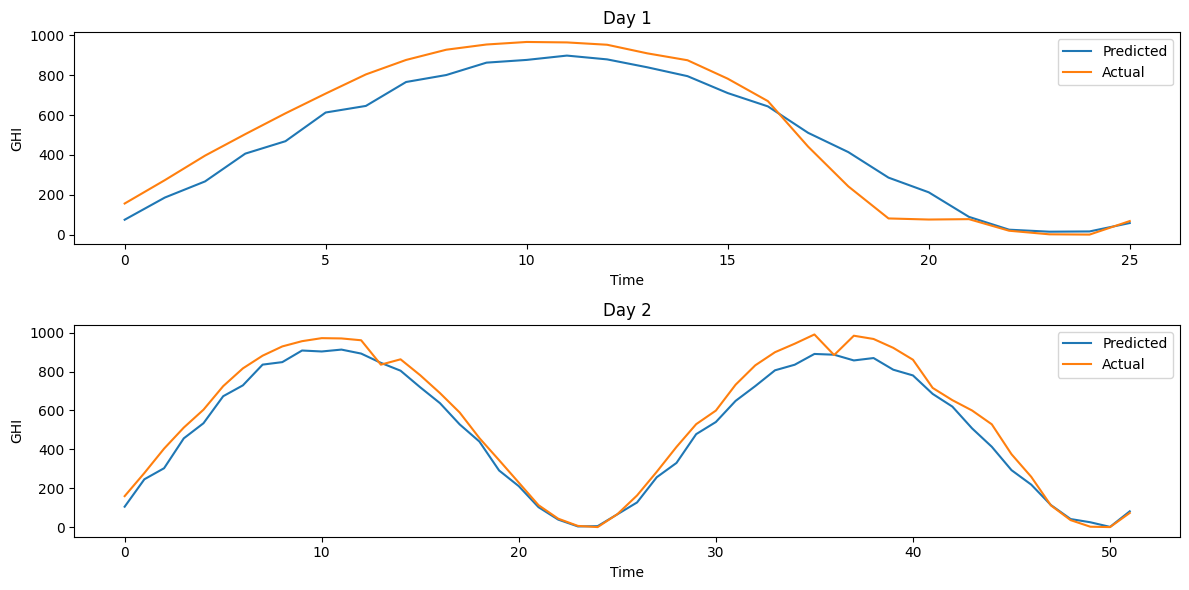

In [64]:

# Split data into two days
day1_predictions = predictions[1][:26]
day2_predictions = predictions[1][26:]



day1_test_y = dataY_t[1][:26]
day2_test_y = dataY_t[1][26:]
# day1_test_y = scaler.inverse_transform(day1_test_y)
# day2_test_y = scaler.inverse_transform(day2_test_y)

# Plot the data
plt.figure(figsize=(12, 6))

# Day 1
plt.subplot(2, 1, 1)
plt.plot(day1_predictions, label='Predicted')
plt.plot(day1_test_y, label='Actual')
plt.title('Day 1')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.legend()

# Day 2
plt.subplot(2, 1, 2)
plt.plot(day2_predictions, label='Predicted')
plt.plot(day2_test_y, label='Actual')
plt.title('Day 2')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.legend()

plt.tight_layout()
plt.show()

(78,)
(78,)


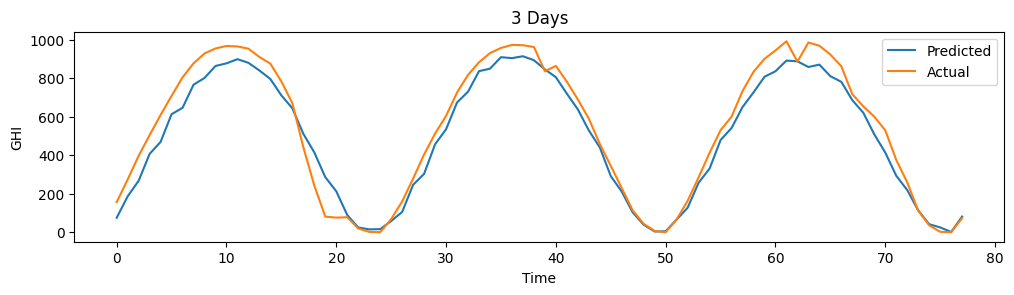

In [65]:
# Split data into two days
TwoDays_predictions = predictions[1][:78]
# day2_predictions = predictions[1][26:]



TwoDays_test_y = dataY_t[1][:78]
# day2_test_y = dataY_t[1][26:]
# TwoDays_test_y = scaler.inverse_transform(TwoDays_test_y)
# day2_test_y = scaler.inverse_transform(day2_test_y)

print(TwoDays_predictions.shape)
print(TwoDays_test_y.shape)
# Plot the data
plt.figure(figsize=(12, 6))

# Day 1
plt.subplot(2, 1, 1)
plt.plot(TwoDays_predictions, label='Predicted')
plt.plot(TwoDays_test_y, label='Actual')
plt.title('3 Days')
plt.xlabel('Time')
plt.ylabel('GHI')
plt.legend()

In [ ]:
# predictions = predictions.reshape(-1, 1)
# Y_test = Y_test.reshape(-1, 1)

In [ ]:

# Assuming p_df is your DataFrame with 'date_time' and prediction/actual columns

# Convert the 'date_time' column to a list (limiting to length of prediction)
dates = df_t['date_time'].tolist()[:len(predictions)]
# print(dates)
# Ensure predictions and Y_test are 1-dimensional and the same length
predictions = predictions.flatten()[:len(dates)]
dataY_t = dataY_t.flatten()[:len(dates)]

# Create the plot
plt.figure(figsize=(20, 10))
plt.plot(dates, predictions, label='Predicted')
plt.plot(dates, dataY_t, label='Actual')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'predictions' is not defined